In [1]:
from model import *

verbose = True

# ---------------------------
# Load parameters
data_params = load_synthdata_params('/config/synthdataconfig.jsonc')
model_params = load_model_params('/config/modelconfig.jsonc')
# ---------------------------


# ---------------------------
# Synthetic data
data_args = {
    "num_samples":data_params['num_samples'],
    "num_feats":data_params['num_nodes'],
    "num_nodes":data_params['num_nodes'],
    "filt_order":data_params['filt_order'],
    "LINK_LAB_SIG":data_params['LINK_LAB_SIG'],
    "LINK_LAB_STRUC":data_params['LINK_LAB_STRUC'],
    "LINK_SIG_STRUC":data_params['LINK_SIG_STRUC']
}
ret = generate_synthdata(**data_args)
gae_data = ret['dataset']
num_classes = ret['num_classes']
num_data_feats = ret['num_data_feats']
num_samples = ret['num_samples']
all_num_nodes = ret['all_num_nodes']
median_num_nodes = ret['median_num_nodes']
num_ls_feats = 21

num_train_samples = int(num_samples*model_params['train_ratio'])
num_val_samples = int(num_samples*model_params['val_ratio'])
num_miss_samples = int(num_samples*model_params['miss_ratio'])
num_test_samples = num_samples - num_train_samples - num_val_samples - num_miss_samples

if verbose:
    print(f'No. classes: {num_classes}')
    print(f'No. data feats.: {num_data_feats}')
    print(f'No. GAE feats.: {num_ls_feats}')
    print(f'No. samples: {num_samples}')
    print(f'Median no. nodes: {median_num_nodes}')
    print('')
# ---------------------------

# ---------------------------
params = model_params

gae_args = {
    'in_dim':num_ls_feats,
    'out_dim':num_ls_feats,
    'hid_dim':params['gae_hid_dim'],
    'lat_dim':params['gae_lat_dim'],
    'n_layers_enc':params['gae_n_layers'],
    'n_layers_dec':params['gae_n_layers'],
    'nonlin':torch.nn.Sigmoid,
    'batch_train_size':params['batch_train_size'],
    'batch_val_size':params['batch_val_size'],
    'lr':params['gae_lr'],
    'lmbda':params['gae_lmbda'],
    'gamma':params['gae_gamma'],
    'patience':params['gae_patience'],
    'epochs':params['gae_epochs'],
}

gnn_args = {
    "batch_train_size":params['batch_train_size'],
    "batch_val_size":params['batch_val_size'],
    "batch_test_size":params['batch_test_size'],
    "num_feats":num_data_feats,
    "num_classes":num_classes,
    "num_hid":params['gnn_hid_dim'],
    "lr":params['gnn_lr'],
    "lmbda":params['gnn_lmbda'],
    "gamma":params['gnn_gamma'],
    "patience":params['gnn_patience'],
    "epochs":params['gnn_epochs'],
}
# ---------------------------


# ---------------------------
# Train models for graph classification
exp_list = []

for i_trial in range(params['num_trials']):
    if verbose:
        print(f"Trial {i_trial+1} of {params['num_trials']}")

    shuff_inds = np.random.permutation(num_samples)
    gae_train_data = list(map(lambda i:gae_data[i],shuff_inds[:num_train_samples]))
    gae_miss_data = list(map(lambda i:gae_data[i],shuff_inds[num_train_samples:num_train_samples+num_miss_samples]))
    gae_val_data = list(map(lambda i:gae_data[i],shuff_inds[num_train_samples+num_miss_samples:num_train_samples+num_miss_samples+num_val_samples]))
    gae_test_data = list(map(lambda i:gae_data[i],shuff_inds[num_test_samples:]))

    gae_exp = GAE_Experiment(gae_train_data,gae_val_data,verbose)
    gae_exp.train_model(**gae_args)

    exp_featpreds = dict(zip(params['PRED_FEAT_TYPES'],[None]*len(params['PRED_FEAT_TYPES'])))

    for PRED_FEAT_TYPE in params['PRED_FEAT_TYPES']:
        if verbose:
            print(f'Prediction type: {PRED_FEAT_TYPE}')
        if PRED_FEAT_TYPE!='lse':
            gae_miss_data_pred = list(map(lambda sample:pred_node_feats_simple(sample,PRED_FEAT_TYPE,verbose),gae_miss_data))
        else:
            gae_miss_data_pred = list(map(lambda sample:pred_node_feats_lse(sample,gae_train_data,gae_exp.autoenc,params['k_graph'],params['k_node']),gae_miss_data))

        gnn_train_data = list(map(lambda sample:nodefeat_to_pyg(sample), gae_train_data + gae_miss_data_pred))
        gnn_val_data = list(map(lambda sample:nodefeat_to_pyg(sample), gae_val_data))
        gnn_test_data = list(map(lambda sample:nodefeat_to_pyg(sample), gae_test_data))

        gin_exp = GIN_Experiment(gnn_train_data,gnn_val_data,gnn_test_data,"GIN",verbose)
        gin_exp.train_model(**gnn_args)
    
        exp_featpreds[PRED_FEAT_TYPE] = ( gae_exp, gin_exp )
    
    exp_list.append( exp_featpreds )
# ---------------------------


No. classes: 2
No. data feats.: 40
No. GAE feats.: 21
No. samples: 300
Median no. nodes: 40

Trial 1 of 3
Epoch: 000 | Train loss: 3.963, Val loss: 29.498
Epoch: 100 | Train loss: 0.218, Val loss: 0.114
Epoch: 200 | Train loss: 0.017, Val loss: 0.020
Epoch: 300 | Train loss: 0.006, Val loss: 0.012
Epoch: 400 | Train loss: 0.002, Val loss: 0.003
Final: 478 | Train loss: 0.002, Val loss: 0.001

Prediction type: true


/home/vtenorio/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch: 000 | Train loss: 0.616, Val loss: 2.293, Test loss: 2.286 | Train acc: 0.667, Val acc: 0.600, Test acc: 0.607
Epoch: 040 | Train loss: 0.132, Val loss: 1.008, Test loss: 0.220 | Train acc: 0.946, Val acc: 0.633, Test acc: 0.922
Epoch: 080 | Train loss: 0.022, Val loss: 1.950, Test loss: 0.325 | Train acc: 0.988, Val acc: 0.633, Test acc: 0.933
Epoch: 120 | Train loss: 0.041, Val loss: 1.133, Test loss: 0.220 | Train acc: 0.983, Val acc: 0.767, Test acc: 0.941
Epoch: 160 | Train loss: 0.019, Val loss: 1.500, Test loss: 0.315 | Train acc: 0.992, Val acc: 0.767, Test acc: 0.937
Final: 009 | Train loss: 0.304, Val loss: 0.429, Test loss: 0.360 | Train acc: 0.887, Val acc: 0.733, Test acc: 0.844

Prediction type: zeros
Epoch: 000 | Train loss: 0.639, Val loss: 3.591, Test loss: 2.117 | Train acc: 0.654, Val acc: 0.567, Test acc: 0.589
Epoch: 040 | Train loss: 0.121, Val loss: 1.225, Test loss: 0.403 | Train acc: 0.925, Val acc: 0.767, Test acc: 0.919
Epoch: 080 | Train loss: 0.133, 

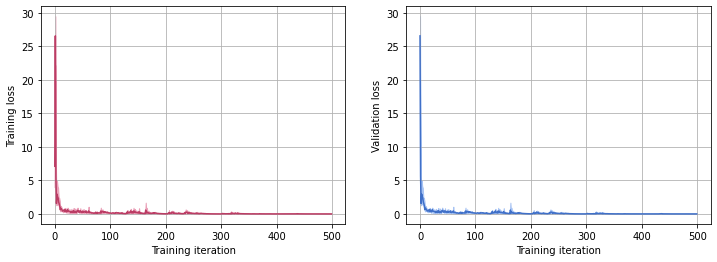

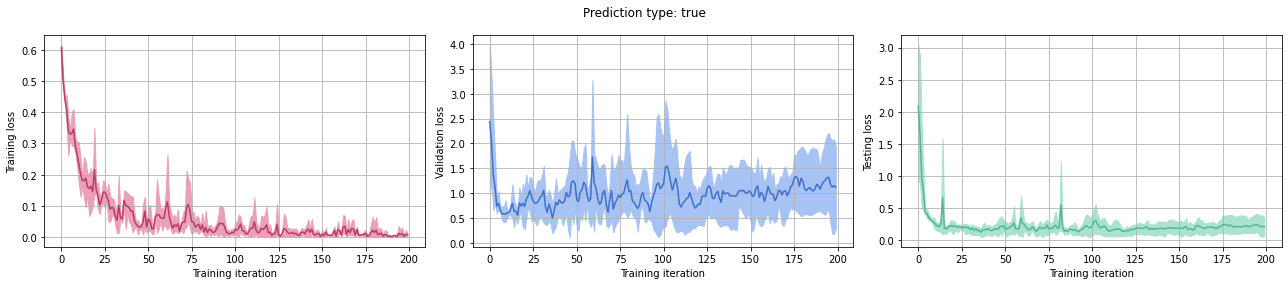

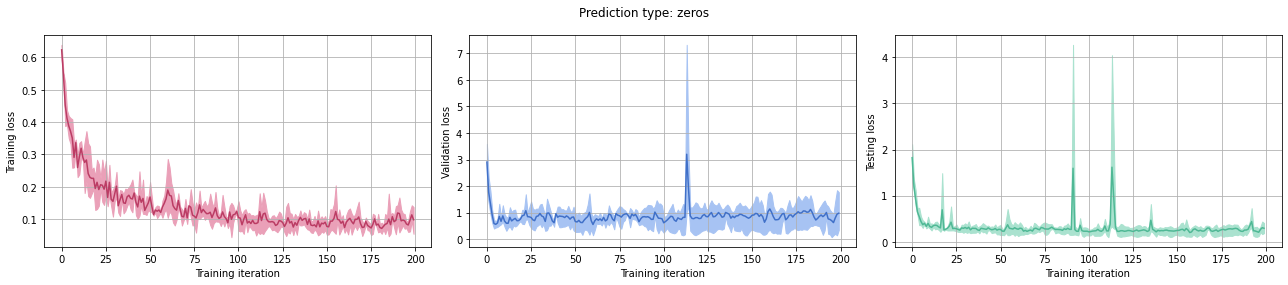

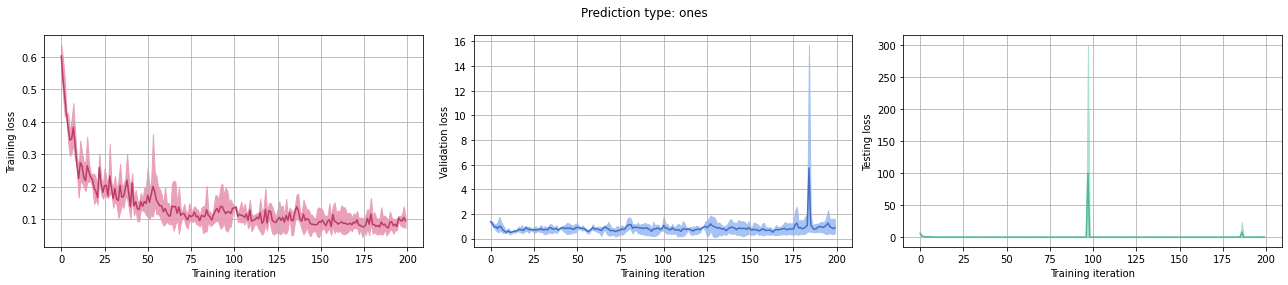

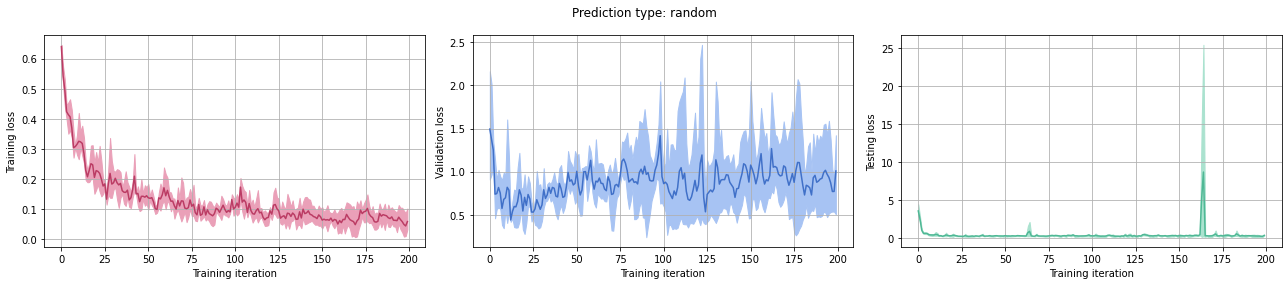

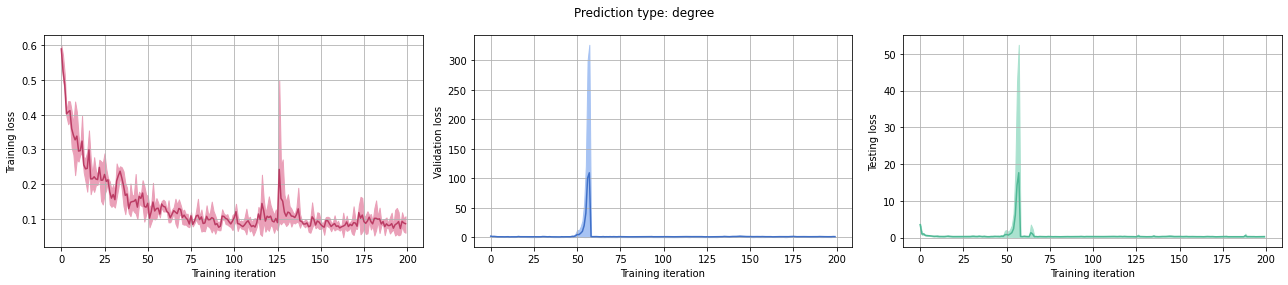

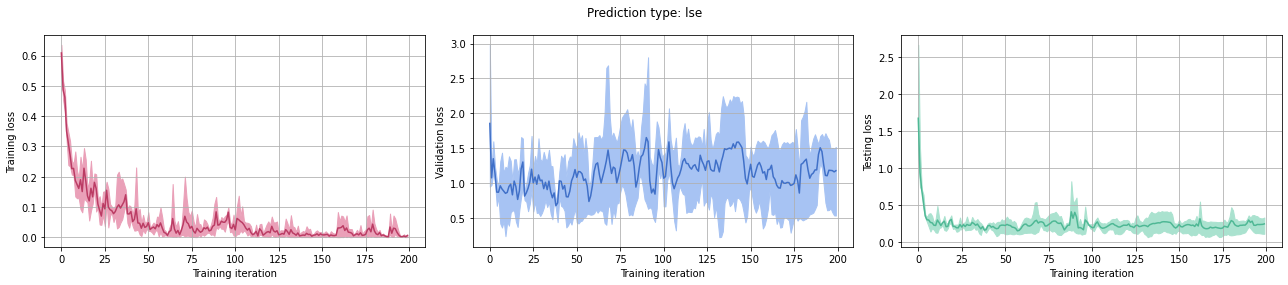

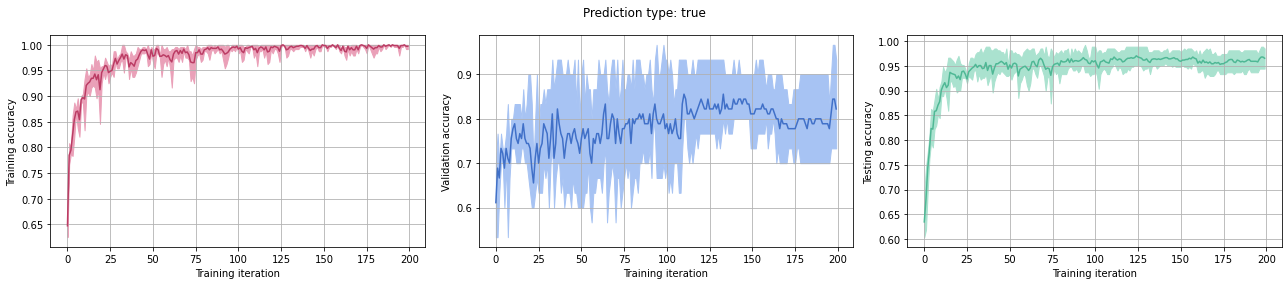

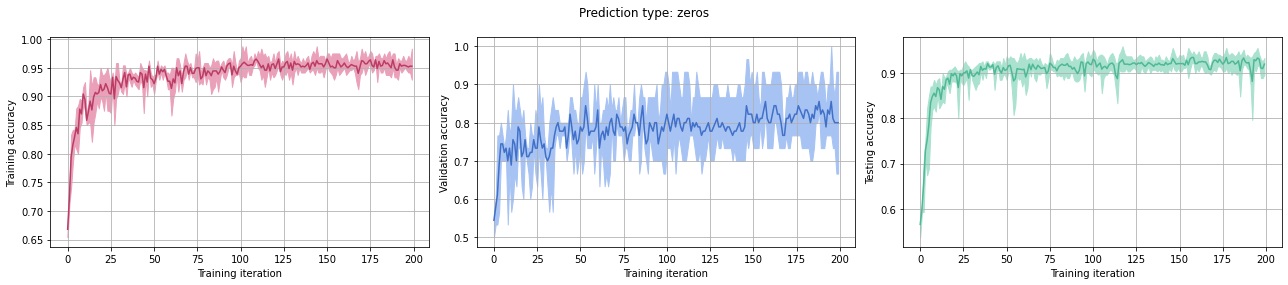

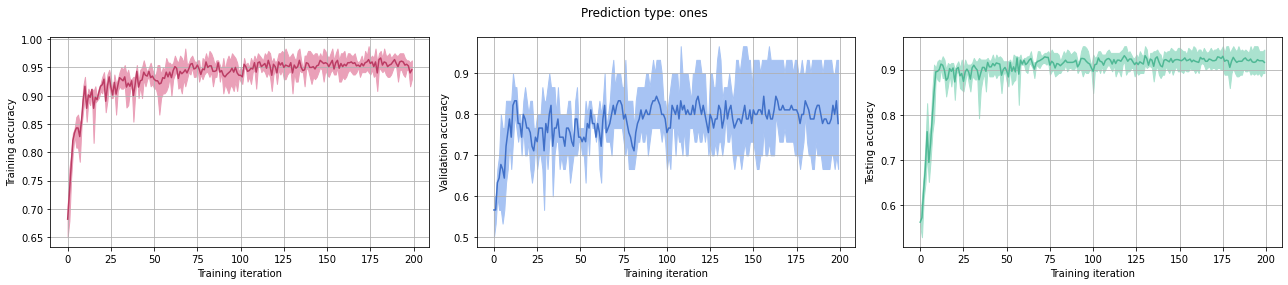

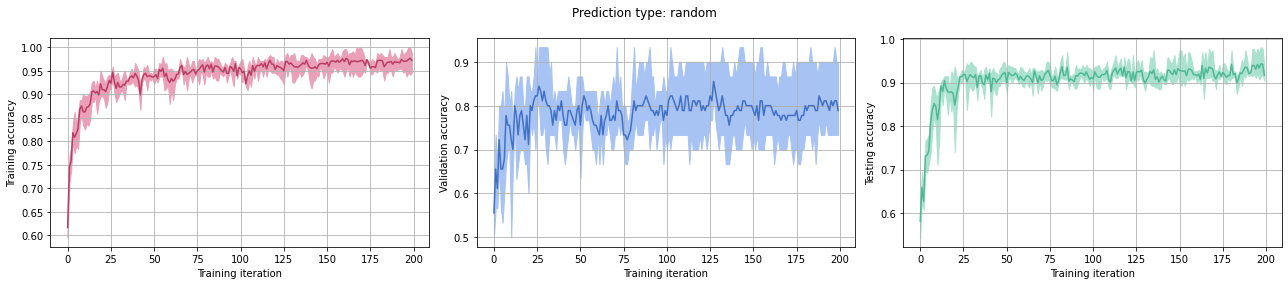

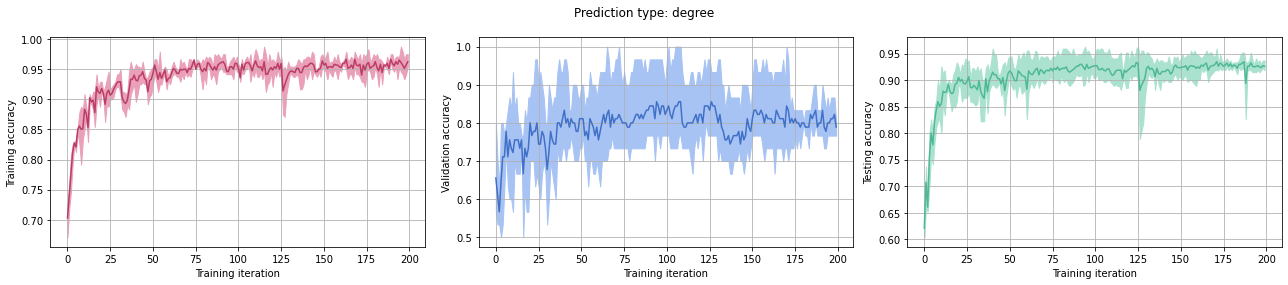

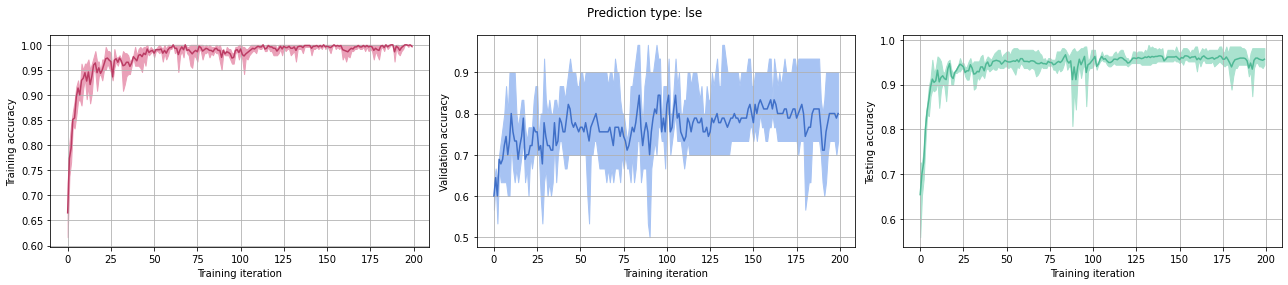

In [2]:
# Plot loss during training for GAE
gae_train_loss_avg = np.mean([exp_list[i_trial]['true'][0].train_loss_iters for i_trial in range(params['num_trials'])],axis=0)
gae_train_loss_min = np.min([exp_list[i_trial]['true'][0].train_loss_iters for i_trial in range(params['num_trials'])],axis=0)
gae_train_loss_max = np.max([exp_list[i_trial]['true'][0].train_loss_iters for i_trial in range(params['num_trials'])],axis=0)

gae_val_loss_avg = np.mean([exp_list[i_trial]['true'][0].val_loss_iters for i_trial in range(params['num_trials'])],axis=0)
gae_val_loss_min = np.min([exp_list[i_trial]['true'][0].val_loss_iters for i_trial in range(params['num_trials'])],axis=0)
gae_val_loss_max = np.max([exp_list[i_trial]['true'][0].val_loss_iters for i_trial in range(params['num_trials'])],axis=0)

fig = plt.figure(figsize=(2*6,4))
ax = fig.subplots(1,2)
ax[0].plot(gae_train_loss_avg,'-',c=reds[13])
ax[0].fill_between(np.arange(params['gae_epochs']),gae_train_loss_min,gae_train_loss_max,color=reds[4])
ax[0].grid(True)
ax[0].set_xlabel(f'Training iteration')
ax[0].set_ylabel(f'Training loss')
ax[1].plot(gae_val_loss_avg,'-',c=blues[12])
ax[1].fill_between(np.arange(params['gae_epochs']),gae_val_loss_min,gae_val_loss_max,color=blues[3])
ax[1].grid(True)
ax[1].set_xlabel(f'Training iteration')
ax[1].set_ylabel(f'Validation loss')

# Plot loss during training for GIN
for PRED_FEAT_TYPE in params['PRED_FEAT_TYPES']:
    gin_train_loss_avg = np.mean([exp_list[i_trial][PRED_FEAT_TYPE][1].train_loss_iters for i_trial in range(params['num_trials'])],axis=0)
    gin_train_loss_min = np.min([exp_list[i_trial][PRED_FEAT_TYPE][1].train_loss_iters for i_trial in range(params['num_trials'])],axis=0)
    gin_train_loss_max = np.max([exp_list[i_trial][PRED_FEAT_TYPE][1].train_loss_iters for i_trial in range(params['num_trials'])],axis=0)

    gin_val_loss_avg = np.mean([exp_list[i_trial][PRED_FEAT_TYPE][1].val_loss_iters for i_trial in range(params['num_trials'])],axis=0)
    gin_val_loss_min = np.min([exp_list[i_trial][PRED_FEAT_TYPE][1].val_loss_iters for i_trial in range(params['num_trials'])],axis=0)
    gin_val_loss_max = np.max([exp_list[i_trial][PRED_FEAT_TYPE][1].val_loss_iters for i_trial in range(params['num_trials'])],axis=0)

    gin_test_loss_avg = np.mean([exp_list[i_trial][PRED_FEAT_TYPE][1].test_loss_iters for i_trial in range(params['num_trials'])],axis=0)
    gin_test_loss_min = np.min([exp_list[i_trial][PRED_FEAT_TYPE][1].test_loss_iters for i_trial in range(params['num_trials'])],axis=0)
    gin_test_loss_max = np.max([exp_list[i_trial][PRED_FEAT_TYPE][1].test_loss_iters for i_trial in range(params['num_trials'])],axis=0)

    fig = plt.figure(figsize=(3*6,4))
    ax = fig.subplots(1,3)
    ax[0].plot(gin_train_loss_avg,'-',c=reds[13])
    ax[0].fill_between(np.arange(params['gnn_epochs']),gin_train_loss_min,gin_train_loss_max,color=reds[4])
    ax[0].grid(True)
    ax[0].set_xlabel(f'Training iteration')
    ax[0].set_ylabel(f'Training loss')
    ax[1].plot(gin_val_loss_avg,'-',c=blues[12])
    ax[1].fill_between(np.arange(params['gnn_epochs']),gin_val_loss_min,gin_val_loss_max,color=blues[3])
    ax[1].grid(True)
    ax[1].set_xlabel(f'Training iteration')
    ax[1].set_ylabel(f'Validation loss')
    ax[2].plot(gin_test_loss_avg,'-',c=greens[12])
    ax[2].fill_between(np.arange(params['gnn_epochs']),gin_test_loss_min,gin_test_loss_max,color=greens[3])
    ax[2].grid(True)
    ax[2].set_xlabel(f'Training iteration')
    ax[2].set_ylabel(f'Testing loss')
    fig.suptitle(f'Prediction type: {PRED_FEAT_TYPE}')
    fig.tight_layout()


# Plot accuracy during training for GIN
for PRED_FEAT_TYPE in params['PRED_FEAT_TYPES']:
    gin_train_acc_avg = np.mean([exp_list[i_trial][PRED_FEAT_TYPE][1].train_acc_iters for i_trial in range(params['num_trials'])],axis=0)
    gin_train_acc_min = np.min([exp_list[i_trial][PRED_FEAT_TYPE][1].train_acc_iters for i_trial in range(params['num_trials'])],axis=0)
    gin_train_acc_max = np.max([exp_list[i_trial][PRED_FEAT_TYPE][1].train_acc_iters for i_trial in range(params['num_trials'])],axis=0)

    gin_val_acc_avg = np.mean([exp_list[i_trial][PRED_FEAT_TYPE][1].val_acc_iters for i_trial in range(params['num_trials'])],axis=0)
    gin_val_acc_min = np.min([exp_list[i_trial][PRED_FEAT_TYPE][1].val_acc_iters for i_trial in range(params['num_trials'])],axis=0)
    gin_val_acc_max = np.max([exp_list[i_trial][PRED_FEAT_TYPE][1].val_acc_iters for i_trial in range(params['num_trials'])],axis=0)

    gin_test_acc_avg = np.mean([exp_list[i_trial][PRED_FEAT_TYPE][1].test_acc_iters for i_trial in range(params['num_trials'])],axis=0)
    gin_test_acc_min = np.min([exp_list[i_trial][PRED_FEAT_TYPE][1].test_acc_iters for i_trial in range(params['num_trials'])],axis=0)
    gin_test_acc_max = np.max([exp_list[i_trial][PRED_FEAT_TYPE][1].test_acc_iters for i_trial in range(params['num_trials'])],axis=0)

    fig = plt.figure(figsize=(3*6,4))
    ax = fig.subplots(1,3)
    ax[0].plot(gin_train_acc_avg,'-',c=reds[13])
    ax[0].fill_between(np.arange(params['gnn_epochs']),gin_train_acc_min,gin_train_acc_max,color=reds[4])
    ax[0].grid(True)
    ax[0].set_xlabel(f'Training iteration')
    ax[0].set_ylabel(f'Training accuracy')
    ax[1].plot(gin_val_acc_avg,'-',c=blues[12])
    ax[1].fill_between(np.arange(params['gnn_epochs']),gin_val_acc_min,gin_val_acc_max,color=blues[3])
    ax[1].grid(True)
    ax[1].set_xlabel(f'Training iteration')
    ax[1].set_ylabel(f'Validation accuracy')
    ax[2].plot(gin_test_acc_avg,'-',c=greens[12])
    ax[2].fill_between(np.arange(params['gnn_epochs']),gin_test_acc_min,gin_test_acc_max,color=greens[3])
    ax[2].grid(True)
    ax[2].set_xlabel(f'Training iteration')
    ax[2].set_ylabel(f'Testing accuracy')
    fig.suptitle(f'Prediction type: {PRED_FEAT_TYPE}')
    fig.tight_layout()

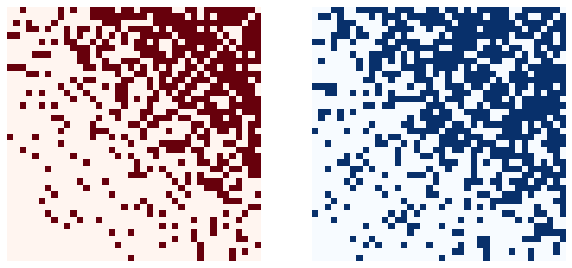

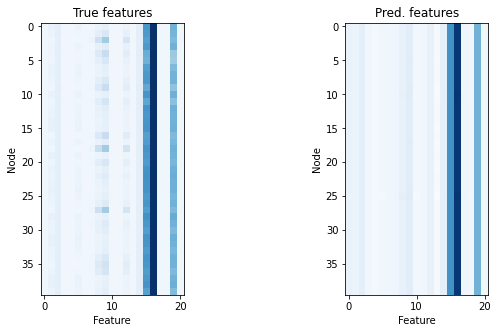

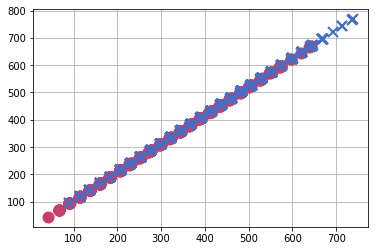

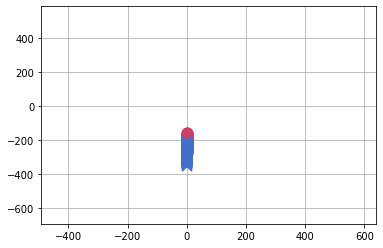

In [3]:
# Plot graphs in different classes
Y_inds = [torch.where(torch.tensor(list(map(lambda i_samp:gae_data[i_samp].Y,np.arange(num_samples))))==iy)[0] for iy in [0,1]]
i_samp = 0
cmap_per_class = ['Reds','Blues']
fig = plt.figure(figsize=(2*5,5))
ax = fig.subplots(1,2)
iy = 0
A_curr = gae_data[Y_inds[iy][i_samp]].A
sort_inds = torch.argsort(torch.sum(A_curr,axis=0))
A_curr = A_curr[sort_inds][:,sort_inds]
ax[iy].imshow(A_curr,cmap_per_class[iy],origin='lower')
ax[iy].axis('off')
iy = 1
A_curr = gae_data[Y_inds[iy][i_samp]].A
sort_inds = torch.argsort(torch.sum(A_curr,axis=0))
A_curr = A_curr[sort_inds][:,sort_inds]
ax[iy].imshow(A_curr,cmap_per_class[iy],origin='lower')
ax[iy].axis('off')

# Plot features versus predicted features for GAE
i_trial = 0
gae_curr = exp_list[i_trial]['true'][0]
F_pred = list(map(lambda i_samp:gae_curr.autoenc(gae_data[i_samp].F,gae_data[i_samp].Ah).detach().double().numpy(),np.arange(num_samples)))
F_true = list(map(lambda i_samp:gae_data[i_samp].F.double().numpy(),np.arange(num_samples)))
vmax = np.maximum(np.max(F_pred),np.max(F_true))
vmin = np.minimum(np.min(F_pred),np.min(F_true))
for i_trial in [0]:
    gae_curr = exp_list[i_trial]['true'][0]
    for i_samp in [1]:
        vmax = np.maximum(np.max(F_pred[i_samp]),np.max(F_true[i_samp]))
        vmin = np.minimum(np.min(F_pred[i_samp]),np.min(F_true[i_samp]))
        fig = plt.figure(figsize=(2*5,5))
        ax = fig.subplots(1,2)
        ax[0].imshow(gae_data[i_samp].F,mycmap)
        ax[0].imshow(gae_curr.train_data[i_samp].F,mycmap,vmin=vmin,vmax=vmax)
        ax[0].set_xlabel('Feature')
        ax[0].set_ylabel('Node')
        ax[0].set_title('True features')
        ax[1].imshow(F_pred[i_samp],mycmap,vmin=vmin,vmax=vmax)
        ax[1].set_xlabel('Feature')
        ax[1].set_ylabel('Node')
        ax[1].set_title('Pred. features')

# Plot latent node and graph embeddings in different classes for GAE
i_trial = 0
gae_curr = exp_list[i_trial]['true'][0]

Z = list(map(lambda i_samp:gae_curr.autoenc.encode(gae_data[i_samp].F,gae_data[i_samp].Ah).detach().double().numpy(),np.arange(num_samples)))
Y_inds = [torch.where(torch.tensor(list(map(lambda i_samp:gae_data[i_samp].Y,np.arange(num_samples))))==iy)[0] for iy in [0,1]]
Z_per_class = [list(map(lambda i_samp:Z[i_samp],Y_inds[iy])) for iy in [0,1]]

mkrs_per_class = ['o','x']
clrs_per_class = [reds[12],blues[12]]
plt_args = {
    'markersize':10,
    'linewidth':3,
    'markeredgewidth':2
}

# Plot latent node embeddings
fig = plt.figure(figsize=(6,4))
ax = fig.subplots()
ax.grid(True)
for iy in [0,1]:
    # for i_samp in range(len(Y_inds[iy])):
    for i_samp in range(10):
        ax.plot(Z_per_class[iy][i_samp][:,0],Z_per_class[iy][i_samp][:,1],mkrs_per_class[iy],c=clrs_per_class[iy],**plt_args)

# Plot latent graph embeddings
fig = plt.figure(figsize=(6,4))
ax = fig.subplots()
ax.grid(True)
for iy in [0,1]:
    for i_samp in range(len(Y_inds[iy])):
        ax.plot(*np.mean(Z_per_class[iy][i_samp],axis=0),mkrs_per_class[iy],c=clrs_per_class[iy],**plt_args)
